
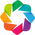

holoviews version 1.8.3


In [2]:
import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews.operation.datashader import aggregate, shade, datashade, dynspread
hv.notebook_extension('bokeh','matplotlib')

import numpy as np
import pandas as pd

#import pymc3 as pm

print('holoviews version',hv.__version__)

In [221]:
%%opts ErrorBars [invert_axes=True show_grid=True  width=600 height=200] (color='slateblue')
%%opts Points [tools=['hover'] toolbar='above'] (color='slateblue' marker='+' size=10 line_width=3)

def forest_plot_example():
    df = pd.DataFrame( dict(
        parameter = ['a','b0','b1','sigma'],
        #parameter = [1.0, 2.0, 3.0,   4.0 ],
        mean      = [2.0, 4.0, 6.0,   8.0 ],
        hpd_25    = [0.0, 2.0, 4.0,   6.0 ],
        hpd_975   = [3.0, 5.0, 7.0,   9.0 ],
        sd        = [0.5, 0.5, 0.5,   0.5 ],
    ))

    rng = (np.floor(df['hpd_25'].min()), np.ceil(df['hpd_975'].max()) )

    e_u = df['hpd_975']- df['mean']
    e_l = df['mean']   - df['hpd_25']

    # Use invisible (i.e., alpha=0) markers to enable hover information
    h = \
        hv.ErrorBars( [i for i in zip(df['parameter'],  df['mean' ], e_l, e_u)],
                    kdims=['parameter'], vdims=['value','e_l','e_u']).opts(style=dict(line_width=1) ) \
      * hv.ErrorBars( zip(df['parameter'],  df['mean' ], df['sd' ] ),
                    kdims=['parameter'], vdims=['value','sd' ]).opts(style=dict(line_width=5) ) \
      * hv.Points( zip(df['parameter'],  df['mean'   ]) ) \
      * hv.Points( zip(df['parameter'],  df['hpd_25' ]) ).opts(style=dict(alpha=0)) \
      * hv.Points( zip(df['parameter'],  df['hpd_975']) ).opts(style=dict(alpha=0))

    return h.redim.range(y=rng)

forest_plot_example().relabel('95% Credible Intervals')

:Overlay
   .ErrorBars.I  :ErrorBars   [parameter]   (value,e_l,e_u)
   .ErrorBars.II :ErrorBars   [parameter]   (value,sd)
   .Points.I     :Points   [x,y]
   .Points.II    :Points   [x,y]
   .Points.III   :Points   [x,y]

In [244]:
%%opts Path Scatter Spread [xticks=4 yticks=4 width=455  show_grid=True]
%%opts Path    (alpha=0.1  color='indianred') Curve (color='black')
%%opts Scatter (alpha=0.03 color='slategray' size=5)
%%opts Spread  (alpha=0.2  color='slategray')


def regression_plot_examples():
    # Least squares problem:  measure y = a + b x + gaussian error; use least squares to estimate a and b; repeat
    N=11; NumExperiments = 1000; a=2.; b=1.; sigma=2.8
    x_vals = np.linspace(-int(N/2),int(N/2),N)
    y_meas = a + b*np.repeat(x_vals.reshape(1,N),NumExperiments,axis=0)  + sigma*np.random.randn( NumExperiments, N )
    # compute the least squares estimates for each experiment
    A              = np.vstack([np.ones(N),x_vals]).T
    ab_estim,_,_,_ = np.linalg.lstsq(A,y_meas.T)
    y_estim        = A.dot(ab_estim).T
    y_estim_ave    = y_estim.mean(axis=0) # averaged y estimates    at each x value
    y_estim_std    = y_estim.std (axis=0) # std of   y estimates    at each x value
    y_meas_ave     = y_meas .mean(axis=0) # averaged y measurements at each x value
    y_meas_std     = y_meas .std (axis=0) # std of   y measurements at each e value

    # Plot the noisy data and the least squares estimates 4 different ways:
    # 1) plot each of the experiments overlaid with the average line and eror bars on the line
    # 2) plot each of the lines estimated by least squares overlaid on each other with ave line and eror bars
    # 3) plot each of the experimantal values overlaid with std of the data and the line estimates
    #    jitter the x locations to get a better view of the number of points involved
    # 4) plot the average estimated line overlaid with estimated line values at each x
    h_data        = hv.Path((x_vals,y_meas.T))
    x_jitter      = np.random.uniform(low=-.05,high=.05,size=(N*NumExperiments))
    h_data_pts    = hv.Scatter( ( np.repeat(x_vals, NumExperiments)+x_jitter, y_meas.T.flatten() ))\
                        (style=dict(color='darkblue', alpha=0.5, size=5))
    h_yestim_line = hv.Path((x_vals,y_estim.T))
    h_yestim_ave  = hv.Curve((x_vals,y_estim_ave))
    h_yestim_std  = hv.ErrorBars((x_vals,y_estim_ave,y_estim_std))
    h_yestim_pts  = hv.Scatter( ( np.repeat(x_vals, NumExperiments), y_estim.T.flatten() ))
    h_spreads_pts = hv.Spread((x_vals, y_estim_ave,y_estim_std))*hv.Spread((x_vals, y_meas_ave, y_meas_std)) *\
                    datashade(h_data_pts)
    #h*h_yestim_ave
    h=\
    (h_data       *h_yestim_std*h_yestim_ave).relabel('Experiments y = %3.2f  + %3.2f x + N(0,%3.2f)'%(a,b,sigma)) +\
    (h_yestim_line*h_yestim_std*h_yestim_ave).relabel('Least Squares Estimate Regression Lines') +\
     (h_yestim_ave*h_spreads_pts            ).relabel('Standard Deviations of Measurements and Estimates') +\
     (h_yestim_ave*h_yestim_pts             ).relabel('Standard Deviations of the Estimated Lines')
    h.cols(2)
    return h

regression_plot_examples().relabel('4 Representations of a Regression')

:Layout
   .Overlay.Experiments_y_equals_2_full_stop_00_plus_1_full_stop_00_x_plus_N_left_parenthesis_0_comma_2_full_stop_80_right_parenthesis :Overlay
      .Path.I      :Path   [x,y]
      .ErrorBars.I :ErrorBars   [x]   (y,yerror)
      .Curve.I     :Curve   [x]   (y)
   .Overlay.Least_Squares_Estimate_Regression_Lines                                                                                    :Overlay
      .Path.I      :Path   [x,y]
      .ErrorBars.I :ErrorBars   [x]   (y,yerror)
      .Curve.I     :Curve   [x]   (y)
   .DynamicMap.Standard_Deviations_of_Measurements_and_Estimates                                                                       :DynamicMap   []
   .Overlay.Standard_Deviations_of_the_Estimated_Lines                                                                                 :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)

In [219]:
%%opts Curve [show_grid=True width=500 height=300] (color='black')
%%opts HLine VLine (color='slategray' alpha=0.3)
%%opts Scatter (size=8 color='coral')

def measurements_and_regression_line():
    N = 10

    x_vals = np.linspace(-10,10,num=N)
    y_vals = 2. + 1.5*x_vals
    y_meas = y_vals + np.random.normal(scale=10.,size=N)
    
    rng = np.floor(min( y_vals.min(),y_meas.min()) )-1, np.ceil( max(y_vals.max(),y_meas.max()) )+1

    h = \
    hv.Curve((x_vals,y_vals)) *hv.HLine(0)*hv.VLine(0) *\
    hv.ErrorBars( (x_vals,y_vals,np.zeros(N), y_meas-y_vals), vdims=['y','0','e'])*\
    hv.Scatter((x_vals,y_meas))
    return h.redim.range(x=(-N-1,N+1), y=(rng))

measurements_and_regression_line().relabel('Measurements and Regression Line')

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .ErrorBars.I :ErrorBars   [x]   (y,0,e)
   .Scatter.I   :Scatter   [x]   (y)

In [252]:
%%opts Curve [show_grid=True width=500 height=300] (color='black')
%%opts HLine VLine (color='slategray' alpha=0.3)
%%opts Scatter (size=8 color='coral')

def estimates_and_line():
    N = 10

    x_vals = np.linspace(-10,10,num=N)
    y_vals = 2. + 1.5*x_vals

    y_meas = np.random.uniform(low=-10., high=15.,size=N)
    e_u    = np.random.uniform(high=12., size=N)
    e_l    = np.random.uniform(high= 8., size=N)

    rng = np.floor((y_vals-e_l).min()) -1, np.ceil((y_vals+e_u).max())+1

    h = \
    hv.Curve((x_vals,y_vals)) *hv.HLine(0)*hv.VLine(0) *\
    hv.ErrorBars( (x_vals,y_meas,e_l, e_u), vdims=['y','e_l','e_u'])*\
    hv.Scatter((x_vals,y_meas))
    return h.redim.range(x=(-N-1,N+1), y=(rng))

estimates_and_line().relabel('Measurements and Line')

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .ErrorBars.I :ErrorBars   [x]   (y,e_l,e_u)
   .Scatter.I   :Scatter   [x]   (y)

In [242]:
%%opts Curve [width=500]
def distribution_example():
    def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
        """Kernel Density Estimation with Scipy"""
        # Note that scipy weights its bandwidth by the covariance of the
        # input data.  To make the results comparable to the other methods,
        # we divide the bandwidth by the sample standard deviation here.

        from scipy.stats import gaussian_kde

        kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
        return kde.evaluate(x_grid)


    N      = 1000
    x      = np.random.normal( size = N )
    x_grid = np.linspace(-4.5, 4.5, 100)
    h = \
    hv.Histogram( *np.histogram(x, 20, normed=True) ).opts(style=dict(fill_color='slateblue', alpha=0.4) ) * \
    hv.Curve((x_grid, kde_scipy( x, x_grid ))).opts(style=dict( color='red') )
    return h

distribution_example().relabel( 'KDE of samples drawn from a Normal Distribution')

:Overlay
   .Histogram.I :Histogram   [x]   (Frequency)
   .Curve.I     :Curve   [x]   (y)

In [264]:
from bokeh.sampledata.iris import flowers
from holoviews.operation import gridmatrix

def splom_example():
    ds = hv.Dataset(flowers)

    grouped_by_species = ds.groupby('species', container_type=hv.NdOverlay)
    grid               = gridmatrix(grouped_by_species, diagonal_type=hv.Histogram)

    plot_opts = dict() #dict(bgcolor='#fafafa')
    style     = dict(alpha=0.5, size=4)

    return grid({'Scatter': {'plot': plot_opts, 'style': style}})
splom_example()

:GridMatrix   [X,Y]
   :NdOverlay   [species]
      :Histogram   [sepal_width]   (Frequency)

In [404]:
%%opts Scatter [width=350 height=350]
def error_concentration_ellipse_example():
    N   = 1000
    A   = np.random.normal(size=(2,N))+3
    A[1,:]=2.3*A[1,:]

    h = hv.Scatter(A.T)

    ave = A.mean(axis=1)
    A   = (A.T-ave).T
    P   = np.cov(A)

    import scipy.linalg as linalg

    deviations = 5
    U,s,v = linalg.svd(P)
    orientation = np.arctan2(U[1,0],U[0,0])

    width  = deviations*np.sqrt(s[0])
    height = deviations*np.sqrt(s[1])

    h = h*\
    hv.Ellipse( ave[0], ave[1], (width,height), orientation=orientation)\
        .redim.range(x=(-1.5*width+ave[0],1.2*width+ave[0]),y=(-1.5*width+ave[1],1.2*width+ave[1]))


    return h.relabel( '%d sigma Error Concentration Ellipse' % deviations)

error_concentration_ellipse_example()

:Overlay
   .Scatter.I :Scatter   [x]   (y)
   .Ellipse.I :Ellipse   [x,y]

In [ ]:
?hv.Ellipse